In [1]:
%load_ext watermark
%watermark
import copy
import pickle
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import sklearn.mixture as mix
from sklearn.externals import joblib
import scipy.stats as scs
from math import ceil

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import seaborn as sns
import missingno as msno
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import affirm 

sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'CamingoCode', 'legend.frameon': True}
sns.set_style('white', style_kwds)

p=print
p()
%watermark -p pandas,pandas_datareader,numpy,scipy,sklearn,matplotlib,seaborn

2017-04-24T07:50:00-06:00

CPython 3.6.0
IPython 5.1.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit

pandas 0.19.2
pandas_datareader 0.3.0.post
numpy 1.12.1
scipy 0.19.0
sklearn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1


In [ ]:
def get_etf_data(mkt, start, end):
    """Function to get benchmark data from 
        Yahoo and Factor data from FRED
    
    Params:
        mkt : str(), symbol
        start : pd.DateTime()
        end : pd.DateTime()
        factors : list() of str()
    Returns:
        data : pd.DataFrame()
    """
    MKT = (web.DataReader([mkt], 'yahoo', start, end)['Adj Close']
           .rename(columns={mkt:mkt})
           .assign(lret=lambda x: np.log(x[mkt]/x[mkt].shift(1)))
           .rename(columns={'lret':mkt+'_lret'}))
           #.dropna())
    # data = data.resample('1W').mean()
    return MKT 

def get_fred_data(factors, start, end):
    """Function to get Factor data from FRED
    
    Params:
        factors : list() of str()    
        start : pd.DateTime()
        end : pd.DateTime()
    Returns:
        data : pd.DataFrame()
    """

    data = (web.DataReader(factors, 'fred', start, end))
            #.dropna())
    return data      

In [2]:
DIR = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/'

In [3]:
%%time
# Project Directory
DIR = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/'
#DIR = '/home/bcr/anaconda3/code_/Mixture_Models/'
# get fed data
f1 = 'TEDRATE' # ted spread
f2 = 'T10Y2Y' # constant maturity ten yer - 2 year
f3 = 'T10Y3M' # constant maturity 10yr - 3m
factors = [f1, f2, f3]

start = pd.to_datetime('2003-12-31')
end = pd.to_datetime('2017-01-01')

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 15.7 ms


In [22]:
# get data and save to disk
list_dfs = []
for mkt in symbols:
    tmp_data = get_etf_data(mkt, start, end)
    list_dfs.append(tmp_data)

agg_etf_data = pd.concat(list_dfs, axis=1, join='inner')
fred_data = get_fred_data(factors, start, end)

mrg_data = agg_etf_data.join(fred_data, how='inner').dropna()
p(mrg_data.info())
p(mrg_data.head())

mrg_data.to_hdf(DIR+'mixture_model_merged_data_01.h5', 'table')    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2449 entries, 2007-01-08 to 2016-12-30
Data columns (total 53 columns):
SPY          2449 non-null float64
SPY_lret     2449 non-null float64
DIA          2449 non-null float64
DIA_lret     2449 non-null float64
QQQ          2449 non-null float64
QQQ_lret     2449 non-null float64
GLD          2449 non-null float64
GLD_lret     2449 non-null float64
TLT          2449 non-null float64
TLT_lret     2449 non-null float64
EEM          2449 non-null float64
EEM_lret     2449 non-null float64
FEZ          2449 non-null float64
FEZ_lret     2449 non-null float64
EZU          2449 non-null float64
EZU_lret     2449 non-null float64
VGK          2449 non-null float64
VGK_lret     2449 non-null float64
EWG          2449 non-null float64
EWG_lret     2449 non-null float64
EWA          2449 non-null float64
EWA_lret     2449 non-null float64
EWC          2449 non-null float64
EWC_lret     2449 non-null float64
EWH          2449 non-null float64


In [4]:
# show johnsonSU vs Normal for a slide  

#%load_ext line_profiler
data = pd.read_hdf(DIR+'mixture_model_merged_data_03.h5', 'table')
p(data.info())
# filename convention
# k-XX-lb-X-step-X-nsamples-XXXX
def _create_dir(DIR, k, lookback, step_fwd, nSamples, year):
    dir_fmt = f'k-{k}_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}'
    if os.path.isdir(DIR + dir_fmt + '/'): 
        pass
    else: os.makedirs(DIR + dir_fmt + '/')
    return dir_fmt

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2970 entries, 2004-11-19 to 2016-12-30
Data columns (total 15 columns):
SPY         2970 non-null float64
SPY_lret    2970 non-null float64
QQQ         2970 non-null float64
QQQ_lret    2970 non-null float64
TLT         2970 non-null float64
TLT_lret    2970 non-null float64
GLD         2970 non-null float64
GLD_lret    2970 non-null float64
EFA         2970 non-null float64
EFA_lret    2970 non-null float64
EEM         2970 non-null float64
EEM_lret    2970 non-null float64
TEDRATE     2970 non-null float64
T10Y2Y      2970 non-null float64
T10Y3M      2970 non-null float64
dtypes: float64(15)
memory usage: 371.2 KB
None


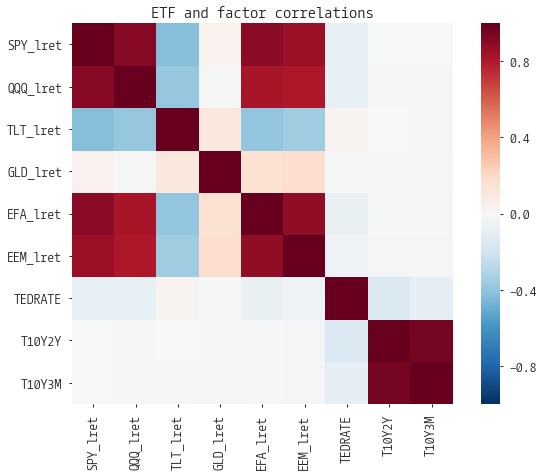

In [13]:
ret_col = [x for x in data.columns if '_lret' in x]
test_cols = ret_col + factors
corr = data[test_cols].corr()

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, square=True, ax=ax)
plt.title('ETF and factor correlations')
fig.savefig(DIR + 'ETF and factor correlations.png', dpi=300, bbox_inches="tight")

In [8]:
%%time

## AGGREGATE PREDICTIONS FIRST; THEN RUN EVALS AND PLOTS AFTER DON'T COMBINE THE LOOP

#DIR2 = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/' #stocks_lookback1step1k16/'

smmrys = []
smmrys_k = []

dcts = []
dcts_k = []

postev = []
postev_k = []

evs = []
evs_k = []

agg_dfs = []
agg_dfs_k = []

# Model Params
# ------------
a, b = (.2, .7) # found via coarse parameter search
alpha = 0.99
max_iter = 50
#k = 3 # n_components
init = 'random' # or 'kmeans'
nSamples = 1_000
#bins = 100
year = 2007 # cutoff
lookback = 1 # years
step_fwd = 3 # days
ks = [2,3,5,7,9,13,17,21]
less_syms = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM', 'DBC']
for k in ks:
    file_fmt = _create_dir(DIR, k, lookback, step_fwd, nSamples, year)
    for mkt in less_syms:
        p('fitting:', mkt)
        ft_cols = [mkt + '_lret'] + factors

        MR_kwds = dict(ft_cols=ft_cols, k=k, init=init, max_iter=max_iter)
        # NOTE this still walks forward by day how?
        #tmp_data = data.copy().resample('1W').mean()
        MR = ModelRunner(data, **MR_kwds)
        dct = MR.prediction_cycle(year, alpha, a, b, nSamples)
        dcts.append((mkt, dct))
        dcts_k.append((k, mkt, dct))
        #p(dct['pred'].head())

        res = ResultEval(mkt, dct, step_fwd=step_fwd)
        event_dict = res._get_event_states()
        event = list(event_dict.keys())[1] #[1] # TOO_LOW

        post_events = res.get_post_events(event_dict[event])
        end_vals = res.get_end_vals(post_events)
        smry = res.create_summary(end_vals)

        postev.append((mkt, post_events))
        postev_k.append((mkt, post_events))
        evs.append((mkt, end_vals))
        evs_k.append((k, mkt, end_vals))
        smmrys.append((mkt, smry))
        smmrys_k.append((k, mkt, smry))

        p()
        p('*'*25)
        p(mkt, event.upper())
        p(smry.T)  

        mp = ModelPlots(mkt, post_events, event, DIR, file_fmt, year)
        agg_tmp_df = mp._agg_temp_event_returns()
        agg_dfs.append((mkt, agg_tmp_df))
        agg_dfs_k.append((k, mkt, agg_tmp_df))

        mp.plot_pred_results(dct['pred'], dct['year'], dct['a'], dct['b'])
        mp.plot_equity_curve(benchmark=data['SPY_lret'])
        mp.plot_distplot(end_vals, smry)

fitting: SPY


NameError: name 'ModelRunner' is not defined

In [16]:
import pickle
smmry_f = f'stocks-lb{lookback}_s{step_fwd}_k{k}_smmrys.txt'
dcts_f = f'stocks-lb{lookback}_s{step_fwd}_k{k}_dcts.txt'
postev_f = f'stocks-lb{lookback}_s{step_fwd}_k{k}_postev.txt'
evs_f = f'stocks-lb{lookback}_s{step_fwd}_k{k}_evs.txt'
agg_dfs_f = f'stocks-lb{lookback}_s{step_fwd}_k{k}_agg_dfs.txt'

In [17]:
pkl_loc = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/four_etf_agg_ks/'
f_suffix = f'k-multiple_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}.txt'
smmry_k_f = pkl_loc + 'smmrys_' + f_suffix
smmry_k_f

'/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/four_etf_agg_ks/smmrys_k-multiple_lb-1_step-3_nsamples-1000.txt'

In [18]:
with open(smmry_k_f, 'wb') as f:
    pickle.dump(smmrys_k, f)   

In [19]:
dcts_k_f = pkl_loc + 'dcts_' + f_suffix
dcts_k_f

'/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/four_etf_agg_ks/dcts_k-multiple_lb-1_step-3_nsamples-1000.txt'

In [20]:
with open(dcts_k_f, 'wb') as f:
    pickle.dump(dcts_k, f)   

In [21]:
postev_k_f = pkl_loc + 'postevs_' + f_suffix

In [24]:
with open(postev_k_f, 'wb') as f:    
    pickle.dump(postev_k, f)

In [25]:
evs_k_f = pkl_loc + 'evs_' + f_suffix

In [26]:
with open(evs_k_f, 'wb') as f:    
    pickle.dump(evs_k, f)

In [29]:
agg_dfs_k_f = pkl_loc + 'aggs_dfs_' + f_suffix

In [30]:
with open(agg_dfs_k_f, 'wb') as f:
    pickle.dump(agg_dfs_k, f)

In [185]:
#with open(DIR + 'lookback1step5k16/lb1_s5_k16_agg_dfs.txt', 'rb') as f:
#    adt = pickle.load(f)

In [31]:
with open(agg_dfs_k_f, 'rb') as f:
    adk = pickle.load(f)

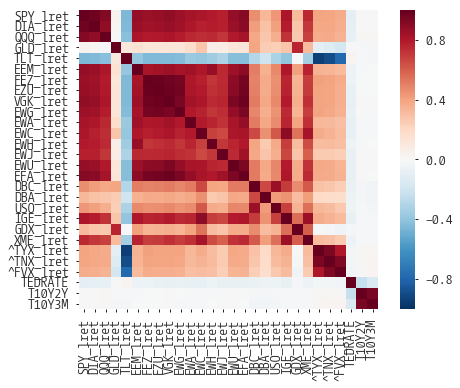

In [126]:
evs[0]

sums = {}
for ev in evs:
    sym, symev = ev
    sums[sym] = sum(symev)

sum(list(sums.values()))

-2.051158500444514

In [111]:
dfs_list = []
for item in agg_dfs:
    sym, dat = item
    dat = dat.rename(sym).to_frame()
    dfs_list.append(dat)
test = pd.concat(dfs_list, axis=0, join_axes=)
test.tail(20)

,DBA,DBC,DIA,EEM,EFA,EWA,EWC,EWG,EWH,EWJ,...,IGE,QQQ,SPY,TLT,USO,VGK,XME,^FVX,^TNX,^TYX
Dates,,,,,,,,,,,,,,,,,,,,,
2009-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171217,NaN,NaN
2009-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.248056,NaN,NaN
2009-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.249278,NaN,NaN
2009-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275191,NaN,NaN
2010-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275191,NaN,NaN
2010-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335416,NaN,NaN
2010-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.366879,NaN,NaN
2010-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471797,NaN,NaN
2011-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.471797,NaN,NaN


In [113]:
max_idx = []
for df in dfs_list:
    if len(max_idx) <= len(df.index):
        max_idx = df.index

In [115]:
max_idx

DatetimeIndex(['2008-01-04', '2008-01-07', '2008-01-08', '2008-01-09',
               '2008-01-17', '2008-01-18', '2008-01-22', '2008-01-23',
               '2008-02-05', '2008-02-06',
               ...
               '2016-09-15', '2016-09-16', '2016-09-29', '2016-09-30',
               '2016-10-03', '2016-10-04', '2016-10-11', '2016-10-12',
               '2016-10-13', '2016-10-14'],
              dtype='datetime64[ns]', name='Dates', length=856, freq=None)

In [ ]:
cutoff = year
train_df = tmp_data.ix[str(cutoff - lookback):str(cutoff)].dropna()
oos = tmp_data.ix[str(cutoff+1):].dropna()
# confirm that train_df end index is different than oos start index
assert train_df.index[-1] != oos.index[0]
oos.head()

i=0
for t in tqdm(oos.index):
    if i == 2:
        break
    p(tmp_data.ix[:t].tail())
    i+=1


In [ ]:
# create pred list to hold tuple rows
preds = []
for t in tqdm(oos.index):
    if t == oos.index[0]:
        insample = train_df

    # run model func to return model object and hidden states using params
    model, hstates = self._run_model(**kwargs)
    # get hidden state mean and variance
    mr_i, mvar_i = self._get_state_est(model, hstates)
    # get confidence intervals from sampled distribution
    low_ci, high_ci = self._get_ci(mr_i, mvar_i, alpha, a, b, nSamples)
    #low_ci, high_ci = self._get_mf_ci(mr_i, mvar_i, alpha, a, b, nSamples, bins)
    # append tuple row to pred list
    preds.append((t, hstates[-1], mr_i, mvar_i, low_ci, high_ci))

    # increment insample dataframe 
    insample = self.data.ix[:t]

In [ ]:
test[ft_cols].ix[str(year):].head()

In [ ]:
end_vals

In [ ]:


too_high_dates = df.query("tgt > high_ci")['Dates']
too_low_dates = df.query("tgt < low_ci")['Dates']

In [ ]:
dir(too_high_dates.diff().iloc[1])

In [ ]:
t = too_high_dates.diff()

cnt = 0
for dt in t:
    try:
        if dt.days < step_fwd:
            cnt += 1
    except: continue
print(cnt)        

In [ ]:
cnt / t.shape[0]



In [ ]:
for name, hex in mpl.colors.cnames.items():
    print(name, hex)

In [ ]:
# code sample from:
#   http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "anglit",          #Anglit
    "arcsine",         #Arcsine
    "beta",            #Beta
    "betaprime",       #Beta Prime
    "bradford",        #Bradford
    "burr",            #Burr
    "cauchy",          #Cauchy
    "chi",             #Chi
    "chi2",            #Chi-squared
    "cosine",          #Cosine
    "dgamma",          #Double Gamma
    "dweibull",        #Double Weibull
    "erlang",          #Erlang
    "expon",           #Exponential
    "exponweib",       #Exponentiated Weibull
    "exponpow",        #Exponential Power
    "fatiguelife",     #Fatigue Life (Birnbaum-Sanders)
    "foldcauchy",      #Folded Cauchy
    "f",               #F (Snecdor F)
    "fisk",            #Fisk
    "foldnorm",        #Folded Normal
    "frechet_r",       #Frechet Right Sided, Extreme Value Type II
    "frechet_l",       #Frechet Left Sided, Weibull_max
    "gamma",           #Gamma
    "gausshyper",      #Gauss Hypergeometric
    "genexpon",        #Generalized Exponential
    "genextreme",      #Generalized Extreme Value
    "gengamma",        #Generalized gamma
    "genlogistic",     #Generalized Logistic
    "genpareto",       #Generalized Pareto
    "genhalflogistic", #Generalized Half Logistic
    "gilbrat",         #Gilbrat
    "gompertz",        #Gompertz (Truncated Gumbel)
    "gumbel_l",        #Left Sided Gumbel, etc.
    "gumbel_r",        #Right Sided Gumbel
    "halfcauchy",      #Half Cauchy
    "halflogistic",    #Half Logistic
    "halfnorm",        #Half Normal
    "hypsecant",       #Hyperbolic Secant
    "invgamma",        #Inverse Gamma
    "invnorm",         #Inverse Normal
    "invweibull",      #Inverse Weibull
    "johnsonsb",       #Johnson SB
    "johnsonsu",       #Johnson SU
    "laplace",         #Laplace
    "logistic",        #Logistic
    "loggamma",        #Log-Gamma
    "loglaplace",      #Log-Laplace (Log Double Exponential)
    "lognorm",         #Log-Normal
    "lomax",           #Lomax (Pareto of the second kind)
    "maxwell",         #Maxwell
    "mielke",          #Mielke's Beta-Kappa
    "nakagami",        #Nakagami
    "ncx2",            #Non-central chi-squared
#    "ncf",             #Non-central F
    "nct",             #Non-central Student's T
    "norm"           # Normal
    "pareto",          #Pareto
    "powerlaw",        #Power-function
    "powerlognorm",    #Power log normal
    "powernorm",       #Power normal
    "rdist",           #R distribution
    "reciprocal",      #Reciprocal
    "rayleigh",        #Rayleigh
    "rice",            #Rice
    "recipinvgauss",   #Reciprocal Inverse Gaussian
    "semicircular",    #Semicircular
    "t",               #Student's T
    "triang",          #Triangular
    "truncexpon",      #Truncated Exponential
    "truncnorm",       #Truncated Normal
    "tukeylambda",     #Tukey-Lambda
    "uniform",         #Uniform
    "vonmises",        #Von-Mises (Circular)
    "wald",            #Wald
    "weibull_min",     #Minimum Weibull (see Frechet)
    "weibull_max",     #Maximum Weibull (see Frechet)
    "wrapcauchy",      #Wrapped Cauchy
    "ksone",           #Kolmogorov-Smirnov one-sided (no stats)
    "kstwobign"]       #Kolmogorov-Smirnov two-sided test for Large N

sample = data['lret'].values
for cdf in cdfs:
    try:
        #fit our data set against every probability distribution
        parameters = eval("scs."+cdf+".fit(sample)");

        #Applying the Kolmogorov-Smirnof one sided test
        D, p = scs.kstest(sample, cdf, args=parameters);

        #pretty-print the results
        D = round(D, 5)
        p = round(p, 5)
        
        #pretty-print the results
        print (cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D));
    except: continue
    

In [ ]:
cdf = 'cdf'
p = 0.00434234
D = 23.54023444


print ("{:{align}} p:{:{width}.{prec}f}".format(cdf, p, width=16, align='<', prec=5))# p: {p:.5f} D: {D:.5f}"